# <center> Construyendo un clasificador de texto con spacy </center>

Primero necesitamos instalar algunos paquetes
```
!pip install spacy==3.3.0
!python -m spacy download en_core_web_md
!pip install spacy-transformers 
```



In [1]:
# !pip install spacy==3.3.0
# !python -m spacy download en_core_web_md
# !pip install spacy-transformers

Necesitamos configurar todo primero:
```
import spacy
import spacy_transformers

# DocBin is spacys way to store Docs in a binary format for training later
from spacy.tokens import DocBin
nlp = spacy.load('en_core_web_md')
```




In [2]:
# import spacy
# import spacy_transformers

# # DocBin is spacys way to store Docs in a binary format for training later
# from spacy.tokens import DocBin
# nlp = spacy.load('en_core_web_md')

Nuestro conjunto de datos de entrenamiento y prueba:
```
prueba_ = pd.read_csv('20news_test.csv')
entrene_ = pd.read_csv('20news_train.csv')
train_data_ = [(entrene_.text[k], entrene_.label[k]) for k in range(len(entrene_))]
valid_data_ = [(prueba_.text[k], prueba_.label[k]) for k in range(len(prueba_))]
```

Luego, necesitamos convertir el texto y las etiquetas en objetos SpaCy Doc.

Lo hacemos con las siguientes dos funciones de abajo, pero primero creamos
una lista con las etiquetas que tenemos en los conjuntos de datos:

```
labels = list(prueba_.label.unique())

def asigna_val(lab, labels):
    labels_dict = dict.fromkeys(labels)
    for k in labels:
        if lab == k:
            labels_dict[k] = 1

def make_docs(data, labels):
    """
    this will take a list of texts and labels
    and transform them in spacy documents
    data: list(tuple(text, label))
    returns: List(spacy.Doc.doc)
    """
    docs = []
    for doc, label in tqdm(nlp.pipe(data, as_tuples=True), total = len(data)):
        mydict = asigna_val(label, labels)
        for j in labels:
            doc.cats[j] = mydict[j]
        docs.append(doc)
    return docs
```

In [3]:
# labels = list(prueba_.label.unique())

# def asigna_val(lab, labels):
#     labels_dict = dict.fromkeys(labels)
#     for k in labels:
#         if lab == k:
#             labels_dict[k] = 1

# def make_docs(data, labels):
#     """
#     this will take a list of texts and labels
#     and transform them in spacy documents
#     data: list(tuple(text, label))
#     returns: List(spacy.Doc.doc)
#     """
#     docs = []
#     for doc, label in tqdm(nlp.pipe(data, as_tuples=True), total = len(data)):
#         mydict = asigna_val(label, labels)
#         for j in labels:
#             doc.cats[j] = mydict[j]
#         docs.append(doc)
#     return docs

Así que:
```
train_docs = make_docs(train_data, labels)
valid_docs = make_docs(valid_data, labels)
        else:
            labels_dict[k] = 0
    return labels_dict
```

In [4]:
# train_docs = make_docs(train_data, labels)
# valid_docs = make_docs(valid_data, labels)
#         else:
#             labels_dict[k] = 0
#     return labels_dict

Ahora solo necesitamos transformar nuestros datos y almacenarlos como un archivo binario en el disco (dentro de la carpeta data):
```
doc_bin = DocBin(docs = train_docs)
doc_bin.to_disk("./data/train.spacy")
doc_bin = DocBin(docs = valid_docs)
doc_bin.to_disk("./data/valid.spacy")
```

In [5]:
# doc_bin = DocBin(docs = train_docs)
# doc_bin.to_disk("./data/train.spacy")
# doc_bin = DocBin(docs = valid_docs)
# doc_bin.to_disk("./data/valid.spacy")

Luego, necesitamos crear archivos de configuración que le digan a SpaCy
lo que se supone que debe aprender de nuestros datos. 
En la página https://spacy.io/, hasta abajo, podemos generar una configuración parcial generada automáticamente para usarlo con `spacy train`:

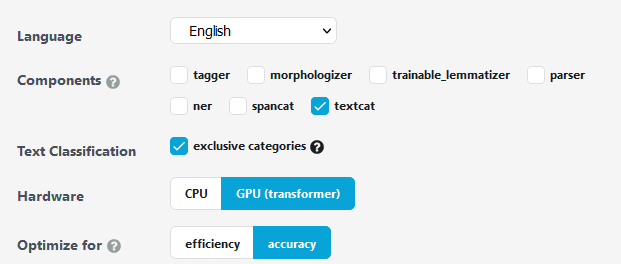

En nuestro caso, elegiríamos "Textcat" en componentes, GPU en hardware y optimizar para accuracy. Y una vez creados los archivos debemos hacer algunos cambios como sustituir `textcat` por `textcat_multilabel` y cambiar las rutas para nuestros datos de entrenamiento y  validación:

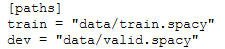

Por lo general, SpaCy proporcionará valores predeterminados sensatos para cada parámetro. No serán los mejores parámetros para nuestro problema, pero funcionarán bien para la mayoría de los datos. 


Si nuestros archivos de configuración son `base_configT.cfg` y `config.cfg`, debemos convertir nuestra configuración base en una configuración completa. Spacy llenará automáticamente todos los valores faltantes con sus parámetros predeterminados, lo hacemos así:

`!python -m spacy init fill-config ./base_configT.cfg ./config.cfg`

Nos arrojará como respuesta:

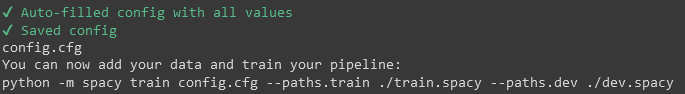

In [6]:
#!python -m spacy init fill-config ./base_configT.cfg ./config.cfg

Finalmente, podemos iniciar el entrenamiento (usando la gpu que nos presta colab):

`!python -m spacy train config.cfg --output ./output --gpu-id 0`

In [7]:
# !python -m spacy train config.cfg --output ./output --gpu-id 0

Nos arrojará como respuesta:

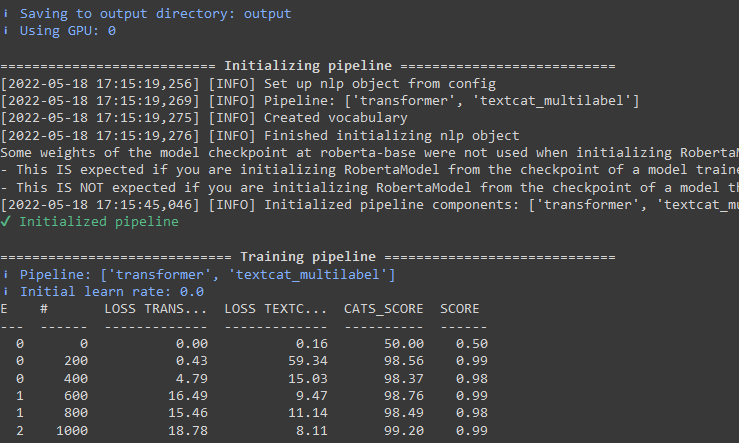

Donde: 
* E — Indica el número de épocas que se han completado.
* \# — Representa los pasos de entrenamiento totales actuales. Podemos cambiar la frecuencia a través de `eval_frequency` en nuestro archivo de configuración.

* `LOSS TEXTCAT` — El valor de la pérdida.
* `CATS_SCORE` — La puntuación de evaluación de 0 a 100.
* `SCORE` — El puntaje de evaluación de 0.0 a 1.0 en dos decimales (redondeado).

El entrenamiento continuará hasta que cumpla alguna de las siguientes condiciones:

* alcanzó los `max_epochs` definidos
* alcanzó los `max_steps` definidos
* alcanzó la `patience` definida (número de pasos sin ninguna mejora en la puntuación)
Guardará el mejor modelo y el último modelo dentro de la carpeta de entrenamiento.

## <center> Cargando el modelo: </center>

Necesitamos entonces importar (o instalar si estamos en otro notebook o la sesión caducó):
```
import spacy_transformers
import spacy
```
Y cargar el mejor modelo que está guardado en la carpeta `output`:

`nlp_ = spacy.load("output/model-best")`

In [8]:
# import spacy_transformers
# import spacy
# nlp_ = spacy.load("output/model-best")

Y ahora sí predecimos con ayuda del siguiente código:
```
text = ""
print("type : ‘quit’ to exit")
# predecir la etiqueta hasta que alguien escriba quit
while text != "quit":
    text = input("input: ")
    doc = nlp_(text)
    print(doc.cats)
```
Nos arrojará algo como:

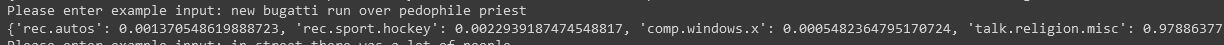

In [9]:
# text = ""
# print("type : ‘quit’ to exit")
# # predecir la etiqueta hasta que alguien escriba quit
# while text != "quit":
#     text = input("input: ")
#     doc = nlp_(text)
#     print(doc.cats)